<a href="https://colab.research.google.com/github/wcwells/generative-ai-for-beginners/blob/main/Copy_of_Keboola_linear_regression_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get This Notebook

Clik on `file` (upper left corner) and choose from the dropdown the option, which you prefer:
- `Save a copy in Drive` to add the notebook to your Google Drive (where you can access it via Google Colab)
- `Download .ipynb` to download the Notebook as a Jupyter Notebook, which you can run from your local machine

# Before we start: Setup

Before we start coding out the solution, make sure you have all the prerequisite Python packages. Run the following code to install the versions of the packages you will be needing for this Notebook.

In [ ]:
# Install necessary pip packages in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pandas==1.0.5 matplotlib==3.2.2 seaborn==0.10.1 numpy==1.18.5 scikit-learn==0.22.2

# Problem Description: Predict price of real estate

You are given a dataset with with historical information about real estate valuation. Your job is to build a linear regression model, which can predict the housing valuation based on the estate's attributes.

The dataset can be [found here](https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set).
</br>
</br>

### Attribute Information

The inputs are as follows</br>
X1=the transaction date (for example, 2013.250=2013 March, 2013.500=2013 June, etc.)</br>
X2=the house age (unit: year)</br>
X3=the distance to the nearest MRT station (unit: meter)</br>
X4=the number of convenience stores in the living circle on foot (integer)</br>
X5=the geographic coordinate, latitude. (unit: degree)</br>
X6=the geographic coordinate, longitude. (unit: degree)</br>
</br>
The output is as follow:</br>
Y= house price of unit area (10000 New Taiwan Dollar/Ping, where Ping is a local unit, 1 Ping = 3.3 meter squared)

# STEP 1: Load & inspect data

In [ ]:
import pandas as pd

dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00477/Real%20estate%20valuation%20data%20set.xlsx'
df = pd.read_excel(dataset_url)

# check the first 5 rows to get a feeling of the data
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


# STEP 2: Exploratory Data Analysis (EDA) & Data Cleaning
Inspect and visualize the data to notice trends.

Clean the data according to [best practices](https://www.keboola.com/blog/the-ultimate-guide-to-data-cleaning).

In [ ]:
# get descriptive statistics for each column/feature
df.describe(include='all')

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,207.500000,2013.148953,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,119.655756,0.281995,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,1.000000,2012.666667,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,104.250000,2012.916667,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,207.500000,2013.166667,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,310.750000,2013.416667,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,414.000000,2013.583333,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


The information above is useful to understand the top down statistics of data (e.g. mean, median, standard deviation), but this works even better, if we visualize the data.

Before we visualize it, though, let us clean it a bit.

First, we remove features, which will not be used in the analysis.

In [ ]:
# remove columns which are unnecessary for linear regression
list_of_columns_to_drop = ['No',
                           'X1 transaction date',
                           'X5 latitude',
                           'X6 longitude']

df.drop(list_of_columns_to_drop, axis=1, inplace=True)

# check if columns dropped properly
df.head()

,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,Y house price of unit area
0,32.0,84.87882,10,37.9
1,19.5,306.59470,9,42.2
2,13.3,561.98450,5,47.3
3,13.3,561.98450,5,54.8
4,5.0,390.56840,5,43.1


Next, check if there are any **missing values** within the dataframe.

In [ ]:
# count the number of rows with missing values per column
df.isna().sum()

X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
Y house price of unit area                0
dtype: int64

All good! No information is missing, so we do not have to remove anything at this moment.

For the next step, we check data distribution, and whether there are any **outliers**. We do it by visualizing the data with box plots.

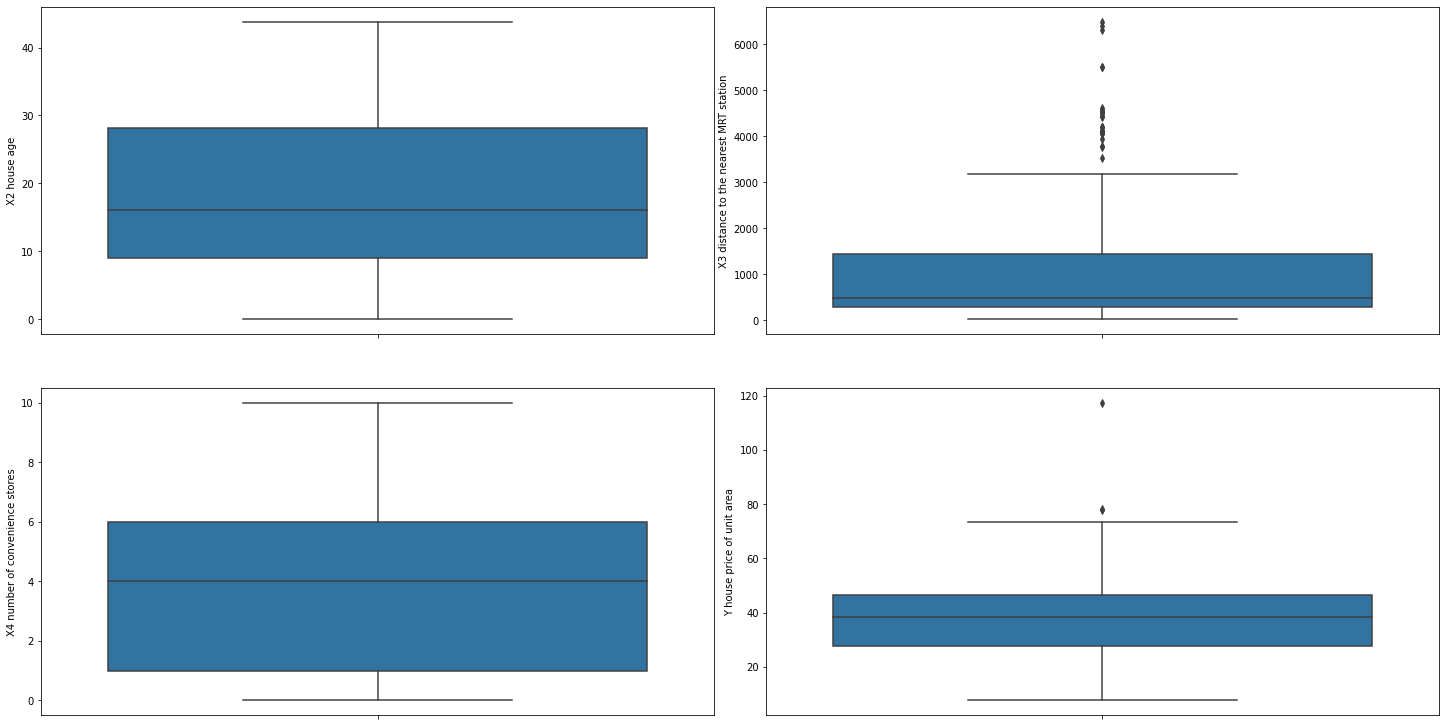

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in df.items():
    sns.boxplot(y=k, data=df, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

From the Box plot we can see that both the house age and number of convenience stores look as if they are not having issues with outliers.

Distance from the nearest MRT station and price of unit area (Y) seem to be both containing a couple of outliers.

For a housing prediction it is expected that some houses will sell above the market price, so at this point we will not remove the outliers in the dependent variable (Y).

But before we continue, let us check the **distribution** of each feature. As you can remember, linear regression assumes a **normal distribution** for each feature.

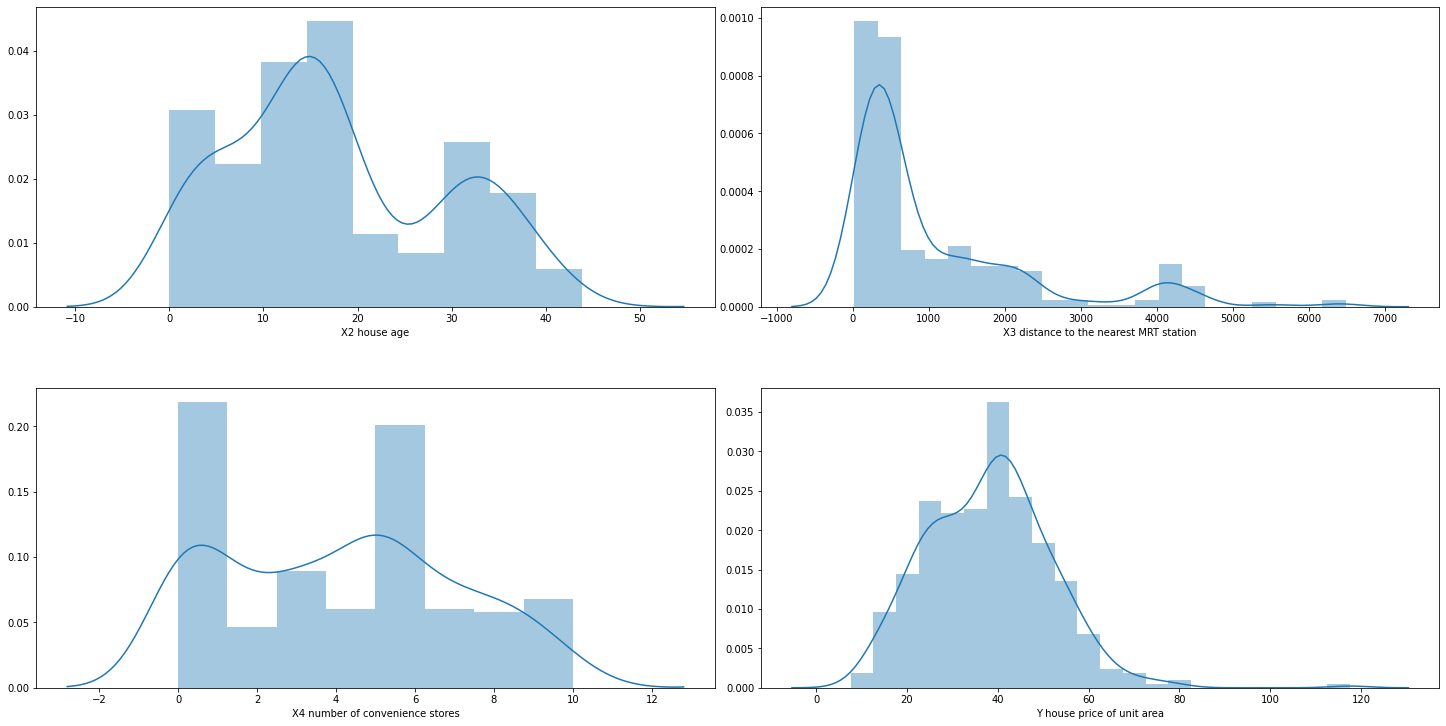

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in df.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

It seems data distribution is slightly problematic. X3 suffers from skewness and a long-tail. X2 seems to be bimodal instead of normal-shaped. The target variable Y, on the other hand, seems to be nicely normally shaped.

For the time being we will just note these potential issues, and continue, with the note-to-ourselves to revisit these distributions in case we need to improve the linear regression model.

## STEP 3: Train and evaluate linear regression model

Start by splitting the data into a training set (for model fitting) and a testing set (for model evaluation).

In [ ]:
from sklearn.model_selection import train_test_split

# separate the features (X) from the target (Y)
Y = df['Y house price of unit area']
X = df[['X2 house age',
        'X3 distance to the nearest MRT station',
        'X4 number of convenience stores']]

# divide the data into a training set (for learning) and test set (for validation)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Train the linear regression model.

In [ ]:
from sklearn.linear_model import LinearRegression

reg_model = LinearRegression()
trained_model = reg_model.fit(x_train, y_train)

Use the model to predict new data and evaluate its performance.

In [ ]:
# make predictions
y_predicted = trained_model.predict(x_test)

# rename y_test into y_true for clarity
y_true = y_test

In [ ]:
from sklearn.metrics import mean_squared_error

# get evaluation metrics
mse = round(mean_squared_error(y_true, y_predicted), 2)
rmse = round(mean_squared_error(y_true, y_predicted, squared=False), 2)
r2 = round(trained_model.score(x_test, y_test), 2)

# evaluate performance
print("Model performance:\nMSE: {}\nRMSE: {}\nR2 score: {}".format(mse, rmse, r2))

Model performance:
MSE: 58.58
RMSE: 7.65
R2 score: 0.65


**Interpretation**: </br>
The model captures some variance in the target variable (R2 score 65%), but could be massively improved.

# Your turn
Improve the model, to perform better than the baseline above.

A couple of things you can explore:
1. Does the model performance improve once we remove outliers?
2. How does feature normalization affect model performance?
3. Add other features (e.g. use longitude and latitude to determine in which area the house is located, bin distance to nearest MRT station to check if there is a signal in the further place, ...). How do new features affect performance?